-----------------------------------------------------------------------------

<h1> MOFs CO2 working capacity prediction with XGBoost </h1>

------------------------------------------------------------

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from IPython.core.display import display
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

<h2>loading dataset</h2>

In [2]:
df = pd.read_csv('Datasets/full_train.csv');df

,MOFname,volume,density,weight,surface_area,void_fraction,void_volume,functional_groups,metal_linker,organic_linker1,...,summetallinker_c,sumothermetallinker,sumorganiclinker_atom1,sumorganiclinker_h1,sumorganiclinker_c1,sumotherorganiclinker1,sumorganiclinker_atom2,sumorganiclinker_h2,sumorganiclinker_c2,sumotherorganiclinker2
0,mof_unit_2,2769.503842,1.326090,2211.697211,603.6100,0.137940,0.104000,F-OMe,10,44,...,0,2,20,6,14,0,40,10,30,0
1,mof_unit_3,1089.818728,1.178856,773.687960,788.5000,0.148740,0.126200,OMe-COOH,2,22,...,6,0,20,12,8,0,14,6,8,0
2,mof_unit_4,2205.198301,0.982408,1304.638720,1441.5300,0.218140,0.222000,H-SO3H,9,17,...,4,2,24,8,16,0,14,6,8,0
3,mof_unit_6,3954.659761,0.647909,1543.027680,2430.5500,0.370940,0.572500,Pr-NO2,9,7,...,4,2,22,8,14,0,24,12,12,0
4,mof_unit_7,3565.914939,0.910268,1954.749656,1530.0200,0.333370,0.366200,NH2,10,53,...,0,2,42,10,26,6,40,14,26,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68283,mof_unit_68606,2112.326167,1.554544,1977.492080,666.7216,0.193031,0.122953,OPr,4,14,...,9,0,16,6,10,0,16,6,10,0
68284,mof_unit_68607,949.067112,1.318868,753.787520,1269.8833,0.302090,0.204770,Pr,2,10,...,6,0,4,2,2,0,28,10,18,0
68285,mof_unit_68608,1202.182553,1.440028,1042.538240,1129.8825,0.267015,0.190208,Ph-Cl,3,12,...,4,2,8,4,4,0,14,6,8,0
68286,mof_unit_68609,1188.302573,1.399781,1001.700216,703.9387,0.144313,0.117899,Pr-F,3,4,...,4,2,14,6,8,0,14,6,8,0


seperate label column

In [3]:
df_label = df['CO2_working_capacity']
df = df.drop(['CO2_working_capacity','MOFname'],axis=1)
print(df.shape,' : ',df_label.shape);df

(68288, 47)  :  (68288,)


,volume,density,weight,surface_area,void_fraction,void_volume,functional_groups,metal_linker,organic_linker1,organic_linker2,...,summetallinker_c,sumothermetallinker,sumorganiclinker_atom1,sumorganiclinker_h1,sumorganiclinker_c1,sumotherorganiclinker1,sumorganiclinker_atom2,sumorganiclinker_h2,sumorganiclinker_c2,sumotherorganiclinker2
0,2769.503842,1.326090,2211.697211,603.6100,0.137940,0.104000,F-OMe,10,44,57,...,0,2,20,6,14,0,40,10,30,0
1,1089.818728,1.178856,773.687960,788.5000,0.148740,0.126200,OMe-COOH,2,22,24,...,6,0,20,12,8,0,14,6,8,0
2,2205.198301,0.982408,1304.638720,1441.5300,0.218140,0.222000,H-SO3H,9,17,24,...,4,2,24,8,16,0,14,6,8,0
3,3954.659761,0.647909,1543.027680,2430.5500,0.370940,0.572500,Pr-NO2,9,7,23,...,4,2,22,8,14,0,24,12,12,0
4,3565.914939,0.910268,1954.749656,1530.0200,0.333370,0.366200,NH2,10,53,55,...,0,2,42,10,26,6,40,14,26,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68283,2112.326167,1.554544,1977.492080,666.7216,0.193031,0.122953,OPr,4,14,14,...,9,0,16,6,10,0,16,6,10,0
68284,949.067112,1.318868,753.787520,1269.8833,0.302090,0.204770,Pr,2,10,18,...,6,0,4,2,2,0,28,10,18,0
68285,1202.182553,1.440028,1042.538240,1129.8825,0.267015,0.190208,Ph-Cl,3,12,24,...,4,2,8,4,4,0,14,6,8,0
68286,1188.302573,1.399781,1001.700216,703.9387,0.144313,0.117899,Pr-F,3,4,24,...,4,2,14,6,8,0,14,6,8,0


<h1>Normalizing</h1>

Normalizing functional groups

In [4]:
def check_in(pattern : str, loop : list or np.ndarray or None = df.functional_groups):
    return [int(pattern in str(x).split('-') )for x in loop]

def count_in(pattern : str, loop : list or np.ndarray or None = df.functional_groups):
    return [str(x).count(pattern) for x in loop]

compounds = set(['SO3H','COOH','NH2','OH','CN','F','OMe','NHMe','NO2','Pr','Cl','OEt','Ph','Br','OPr','HCO','Et','Me','H','I'])
molecules = set(['N','O','C'])

func_data = {
    f'funccheck_{compound}':check_in(compound)
    for compound in compounds
}
func_data.update({
    f'funccount_{molecule}':count_in(molecule)
    for molecule in molecules
})
func_data.update({
    'num_func': [int('-' in str(x)) for x in df.functional_groups]
})

df.functional_groups = df.functional_groups.astype("category").cat.codes
func_df = pd.DataFrame(func_data);func_df

,funccheck_Ph,funccheck_Et,funccheck_CN,funccheck_COOH,funccheck_OH,funccheck_NHMe,funccheck_OEt,funccheck_I,funccheck_NO2,funccheck_F,...,funccheck_Br,funccheck_OMe,funccheck_OPr,funccheck_Pr,funccheck_Me,funccheck_HCO,funccount_N,funccount_O,funccount_C,num_func
0,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,1
1,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,3,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,1,1,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68283,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
68284,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
68285,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
68286,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1


Add more feature

In [5]:
df.insert(
    loc=0,
    column='difatom',
    value=df['sumatom']-df['C+O+H']
)
df.insert(
    loc=0,
    column='surface_to_volume',
    value=df['surface_area']/df['volume']
)
df.insert(
    loc=0,
    column='cubic_surface_area',
    value=((df['volume']**(1/3))**2)*6
)
df.head()

,cubic_surface_area,surface_to_volume,difatom,volume,density,weight,surface_area,void_fraction,void_volume,functional_groups,...,summetallinker_c,sumothermetallinker,sumorganiclinker_atom1,sumorganiclinker_h1,sumorganiclinker_c1,sumotherorganiclinker1,sumorganiclinker_atom2,sumorganiclinker_h2,sumorganiclinker_c2,sumotherorganiclinker2
0,1183.275571,0.217949,21,2769.503842,1.326090,2211.697211,603.61,0.13794,0.1040,115,...,0,2,20,6,14,0,40,10,30,0
1,635.410072,0.723515,2,1089.818728,1.178856,773.687960,788.50,0.14874,0.1262,303,...,6,0,20,12,8,0,14,6,8,0
2,1016.520988,0.653696,5,2205.198301,0.982408,1304.638720,1441.53,0.21814,0.2220,139,...,4,2,24,8,16,0,14,6,8,0
3,1500.458542,0.614604,6,3954.659761,0.647909,1543.027680,2430.55,0.37094,0.5725,373,...,4,2,22,8,14,0,24,12,12,0
4,1400.442353,0.429068,17,3565.914939,0.910268,1954.749656,1530.02,0.33337,0.3662,200,...,0,2,42,10,26,6,40,14,26,0


One-hotting metal/organic linkers and topology

In [6]:
metal_linker_int = df['metal_linker']-1
metal_one_hot = to_categorical(metal_linker_int,num_classes=12,dtype='int8')
metal_onehot_df = pd.DataFrame(metal_one_hot,columns=['ml_' + str(num) for num in range(1,13)])
print(metal_onehot_df.shape)
display(metal_onehot_df.head(2))
#---------------------------------------
org1_int = df['organic_linker1']-1
org1_one_hot = to_categorical(org1_int,num_classes=59,dtype='int8')
org1_onehot_df = pd.DataFrame(org1_one_hot,columns=['ol1_' + str(num) for num in range(1,60)])
print(org1_onehot_df.shape)
display(org1_onehot_df.head(2))
#--------------------------------------
org2_int = df['organic_linker2']-1
org2_one_hot = to_categorical(org2_int,num_classes=59,dtype='int8')
org2_onehot_df = pd.DataFrame(org2_one_hot,columns=['ol2_' + str(num) for num in range(1,60)])
print(org2_onehot_df.shape)
display(org2_onehot_df.head(2))
#--------------------------------------
top_int = df['topology']
top_one_hot = to_categorical(top_int,dtype='int8')
top_onehot_df = pd.DataFrame(top_one_hot,columns=['top_' + str(num) for num in range(0,11)])
print(top_onehot_df.shape)
display(top_onehot_df.head(2))

(68288, 12)


,ml_1,ml_2,ml_3,ml_4,ml_5,ml_6,ml_7,ml_8,ml_9,ml_10,ml_11,ml_12
0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0


(68288, 59)


,ol1_1,ol1_2,ol1_3,ol1_4,ol1_5,ol1_6,ol1_7,ol1_8,ol1_9,ol1_10,...,ol1_50,ol1_51,ol1_52,ol1_53,ol1_54,ol1_55,ol1_56,ol1_57,ol1_58,ol1_59
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(68288, 59)


,ol2_1,ol2_2,ol2_3,ol2_4,ol2_5,ol2_6,ol2_7,ol2_8,ol2_9,ol2_10,...,ol2_50,ol2_51,ol2_52,ol2_53,ol2_54,ol2_55,ol2_56,ol2_57,ol2_58,ol2_59
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(68288, 11)


,top_0,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10
0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0


<h1>Feature selection</h1>

In [7]:
df_col = dict(
    df_geometry_col = [
    'surface_area',
    'void_fraction',
    'density',
    'void_volume',
    'weight',
    'volume',
    ],
    df_function_col = [
    'functional_groups',
    'metal_linker',
    'organic_linker1',
    'organic_linker2',
    'topology',
    'CO2/N2_selectivity',
    'heat_adsorption_CO2_P0.15bar_T298K',
    ],
    df_cif_col = [
    'cell_length_a',
    'cell_length_b',
    'cell_length_c',
    'cell_angle_alpha',
    'cell_angle_beta',
    'cell_angle_gamma',
    'sum_charge',
    'mean_charge',
    ],
    df_xyz_col = [
    'Lattice1', 
    # 'Lattice2',
    # 'Lattice3', 
    'Lattice4', 
    'Lattice5', 
    # 'Lattice6', 
    'Lattice7', 
    'Lattice8',
    'Lattice9', 
    # 'C+O+H', 
    'C', 
    'O', 
    'H', 
    'sumatom',
    ],
    df_add_col = [
    'surface_to_volume',
    'difatom',
    'cubic_surface_area'
    ],
    linker_features = [ 
    'summetallinker_atom', 
    'summetallinker_o', 
    'summetallinker_c',
    'sumothermetallinker', 
    'sumorganiclinker_atom1', 
    'sumorganiclinker_h1',
    'sumorganiclinker_c1', 
    'sumotherorganiclinker1',
    'sumorganiclinker_atom2', 
    'sumorganiclinker_h2', 
    'sumorganiclinker_c2',
    'sumotherorganiclinker2'
    ]
)

df_selected = df[sum(df_col.values(),[])]
df_selected = pd.concat([df_selected,metal_onehot_df,org1_onehot_df,org2_onehot_df,top_onehot_df,func_df],axis=1)
print(df_selected.shape);df_selected.head()

(68288, 211)


,surface_area,void_fraction,density,void_volume,weight,volume,functional_groups,metal_linker,organic_linker1,organic_linker2,...,funccheck_Br,funccheck_OMe,funccheck_OPr,funccheck_Pr,funccheck_Me,funccheck_HCO,funccount_N,funccount_O,funccount_C,num_func
0,603.61,0.13794,1.326090,0.1040,2211.697211,2769.503842,115,10,44,57,...,0,1,0,0,0,0,0,1,0,1
1,788.50,0.14874,1.178856,0.1262,773.687960,1089.818728,303,2,22,24,...,0,1,0,0,0,0,0,3,1,1
2,1441.53,0.21814,0.982408,0.2220,1304.638720,2205.198301,139,9,17,24,...,0,0,0,0,0,0,0,1,0,1
3,2430.55,0.37094,0.647909,0.5725,1543.027680,3954.659761,373,9,7,23,...,0,0,0,1,0,0,1,1,0,1
4,1530.02,0.33337,0.910268,0.3662,1954.749656,3565.914939,200,10,53,55,...,0,0,0,0,0,0,1,0,0,0


In [8]:
linear_scaler = StandardScaler().fit(df_selected)
scaled_data = linear_scaler.transform(df_selected)
scaled_data = pd.DataFrame(scaled_data);scaled_data

,0,1,2,3,4,5,6,7,8,9,...,201,202,203,204,205,206,207,208,209,210
0,-0.977424,-0.827785,0.915807,-0.583688,0.441524,-0.139203,-0.730834,1.845677,2.976613,3.606097,...,-0.276991,2.872824,-0.295352,-0.245608,-0.306551,-0.337553,-0.683693,0.167869,-0.669017,0.599272
1,-0.826126,-0.757611,0.500240,-0.536465,-0.702159,-0.489656,0.984465,-0.700003,0.935528,0.338209,...,-0.276991,2.872824,-0.295352,-0.245608,-0.306551,-0.337553,-0.683693,2.707395,1.226661,0.599272
2,-0.291743,-0.306675,-0.054234,-0.332682,-0.279881,-0.256941,-0.511859,1.527467,0.471645,0.338209,...,-0.276991,-0.348090,-0.295352,-0.245608,-0.306551,-0.337553,-0.683693,0.167869,-0.669017,0.599272
3,0.517585,0.686164,-0.998358,0.412888,-0.090285,0.108071,1.623140,1.527467,-0.456121,0.239183,...,-0.276991,-0.348090,-0.295352,4.071529,-0.306551,-0.337553,1.201777,0.167869,-0.669017,0.599272
4,-0.219330,0.442048,-0.257848,-0.025946,0.237168,0.026962,0.044700,1.845677,3.811602,3.408043,...,-0.276991,-0.348090,-0.295352,-0.245608,-0.306551,-0.337553,1.201777,-1.101894,-0.669017,-1.668690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68283,-0.925779,-0.469825,1.560618,-0.543371,0.255255,-0.276318,1.139572,-0.063583,0.193315,-0.652059,...,-0.276991,-0.348090,3.385792,-0.245608,-0.306551,-0.337553,-0.683693,0.167869,-0.669017,-1.668690
68284,-0.432204,0.238803,0.895423,-0.369333,-0.717986,-0.519023,1.504529,-0.700003,-0.177791,-0.255952,...,-0.276991,-0.348090,-0.295352,4.071529,-0.306551,-0.337553,-0.683693,-1.101894,-0.669017,-1.668690
68285,-0.546768,0.010900,1.237396,-0.400309,-0.488336,-0.466212,1.358546,-0.381793,0.007762,0.338209,...,-0.276991,-0.348090,-0.295352,-0.245608,-0.306551,-0.337553,-0.683693,-1.101894,1.226661,0.599272
68286,-0.895323,-0.786375,1.123799,-0.554122,-0.520815,-0.469108,1.559272,-0.381793,-0.734451,0.338209,...,-0.276991,-0.348090,-0.295352,4.071529,-0.306551,-0.337553,-0.683693,-1.101894,-0.669017,0.599272


In [9]:
linear_reg = LinearRegression()
linear_reg.fit(scaled_data,df_label)
pred = linear_reg.predict(scaled_data)
print(np.log(mean_absolute_error(df_label,pred)))
df_selected.insert(
    loc=0,
    column='linear_pred',
    value=pred
)

3.62977014725958


In [10]:
knn_pred = pd.read_csv('knn_pred.csv')
df_selected = pd.concat([knn_pred['knn_pred'],df_selected],axis=1);df_selected

,knn_pred,linear_pred,surface_area,void_fraction,density,void_volume,weight,volume,functional_groups,metal_linker,...,funccheck_Br,funccheck_OMe,funccheck_OPr,funccheck_Pr,funccheck_Me,funccheck_HCO,funccount_N,funccount_O,funccount_C,num_func
0,74.570425,77.728852,603.6100,0.137940,1.326090,0.104000,2211.697211,2769.503842,115,10,...,0,1,0,0,0,0,0,1,0,1
1,150.716341,116.037446,788.5000,0.148740,1.178856,0.126200,773.687960,1089.818728,303,2,...,0,1,0,0,0,0,0,3,1,1
2,166.817841,155.262055,1441.5300,0.218140,0.982408,0.222000,1304.638720,2205.198301,139,9,...,0,0,0,0,0,0,0,1,0,1
3,81.595126,126.084321,2430.5500,0.370940,0.647909,0.572500,1543.027680,3954.659761,373,9,...,0,0,0,1,0,0,1,1,0,1
4,76.531865,96.553071,1530.0200,0.333370,0.910268,0.366200,1954.749656,3565.914939,200,10,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68283,-2.403779,0.021821,666.7216,0.193031,1.554544,0.122953,1977.492080,2112.326167,320,4,...,0,0,1,0,0,0,0,1,0,0
68284,170.924022,22.248383,1269.8833,0.302090,1.318868,0.204770,753.787520,949.067112,360,2,...,0,0,0,1,0,0,0,0,0,0
68285,77.096460,-84.212554,1129.8825,0.267015,1.440028,0.190208,1042.538240,1202.182553,344,3,...,0,0,0,0,0,0,0,0,1,1
68286,73.297058,7.441743,703.9387,0.144313,1.399781,0.117899,1001.700216,1188.302573,366,3,...,0,0,0,1,0,0,0,0,0,1


In [11]:
neighbor_reg = KNeighborsRegressor(
    n_neighbors=5,
    )
neighbor_reg.fit(scaled_data,df_label)

KNeighborsRegressor()

In [12]:
# pred = neighbor_reg.predict(scaled_data)
# print(np.log10(mean_absolute_error(df_label,pred)))
# df_selected.insert(
#     loc=0,
#     column='knn_pred',
#     value=pred
# )
# knn_pred_df = pd.DataFrame(pred,columns=['pred'])

In [13]:
# knn_pred_df.to_csv('knn_pred.csv')

Feature selection with BoostARoota

In [14]:
# unimportant_col = ["top_7","ol2_59","ol2_39","ol2_37","ol2_34","ol2_33","ol2_32","ol1_58","ol1_57","ol1_37","ol1_33","ol1_31","ml_11","ml_8","ml_7","ml_6","ml_5"]
# df_selected = df_selected.drop(unimportant_col,axis=1)

<h2>convert to array</h2>

In [15]:
df_label_array = np.array(df_label)
df_array = np.array(df_selected)
f'{df_label_array.shape} : {df_array.shape}'

'(68288,) : (68288, 213)'

<h2>train-test split</h2>

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df_array,df_label_array,test_size=0.1,random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.15,random_state=123)
print(f'train : {X_train.shape}\nval : {X_val.shape}\ntest : {X_test.shape}')

train : (52240, 213)
val : (9219, 213)
test : (6829, 213)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_array,df_label_array,test_size=0.15,random_state=69)
print(f'train : {X_train.shape}\ntest : {X_test.shape}')

<h1> Model training </h1>

<h2> Model 1 -XGBoost</h2>

In [17]:
# xg_reg1 = xgb.XGBRegressor(
#     eta = 0.008,
#     seed = 123,
#     max_depth =10,
#     colsample_bytree =0.7,
#     min_child_weight = 6,
#     subsample = 0.7,
#     num_parallel_tree=10,
#     n_estimators = 20000,
#     tree_method='exact',
#     verbosity = 0,
#     )

In [18]:
xg_reg1 = xgb.XGBRegressor(
    eta = 0.1,
    seed = 69,
    max_depth =10,
    subsample = 0.8,
    colsample_bytree =0.8,
    colsample_bylevel = 0.8,
    colsample_bynode = 0.8,
    num_parallel_tree = 5,
    n_estimators = 350,
    tree_method='exact',
    verbosity = 0,
    )

In [19]:
xg_reg1.fit(
    X_train,
    y_train,
    # early_stopping_rounds = 20,
    eval_metric='mae',
    eval_set=[(X_test,y_test)]
    )

[0]	validation_0-mae:107.86697
[1]	validation_0-mae:97.19038
[2]	validation_0-mae:87.54951
[3]	validation_0-mae:78.88367
[4]	validation_0-mae:71.10484
[5]	validation_0-mae:64.10900
[6]	validation_0-mae:57.85903
[7]	validation_0-mae:52.26918
[8]	validation_0-mae:47.27005
[9]	validation_0-mae:42.88596
[10]	validation_0-mae:39.02519
[11]	validation_0-mae:35.68230
[12]	validation_0-mae:32.80712
[13]	validation_0-mae:30.35948
[14]	validation_0-mae:28.31612
[15]	validation_0-mae:26.58432
[16]	validation_0-mae:25.12102
[17]	validation_0-mae:23.90672
[18]	validation_0-mae:22.89047
[19]	validation_0-mae:22.04044
[20]	validation_0-mae:21.32965
[21]	validation_0-mae:20.74261
[22]	validation_0-mae:20.26152
[23]	validation_0-mae:19.85965
[24]	validation_0-mae:19.52865
[25]	validation_0-mae:19.24464
[26]	validation_0-mae:19.02857
[27]	validation_0-mae:18.84423
[28]	validation_0-mae:18.70116
[29]	validation_0-mae:18.57614
[30]	validation_0-mae:18.46989
[31]	validation_0-mae:18.37810
[32]	validation_0

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
             colsample_bynode=0.8, colsample_bytree=0.8, eta=0.1, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=350, n_jobs=8, num_parallel_tree=5, random_state=69,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=69,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=0)

In [20]:
pred = xg_reg1.predict(X_train);lmae_cheat = np.log(mean_absolute_error(y_train,pred));lmae_cheat

1.7294469984508198

In [21]:
pred = xg_reg1.predict(X_test);lmae = np.log(mean_absolute_error(y_test,pred));lmae

2.8778440162163452

In [ ]:
# xg_reg1.save_model("2914.json")
# xg_reg_load = xgb.Booster();xg_reg_load.load_model("2914.json")
# pred = xg_reg_load.predict(xgb.DMatrix(X_test));lmae = np.log(mean_absolute_error(y_test,pred));lmae

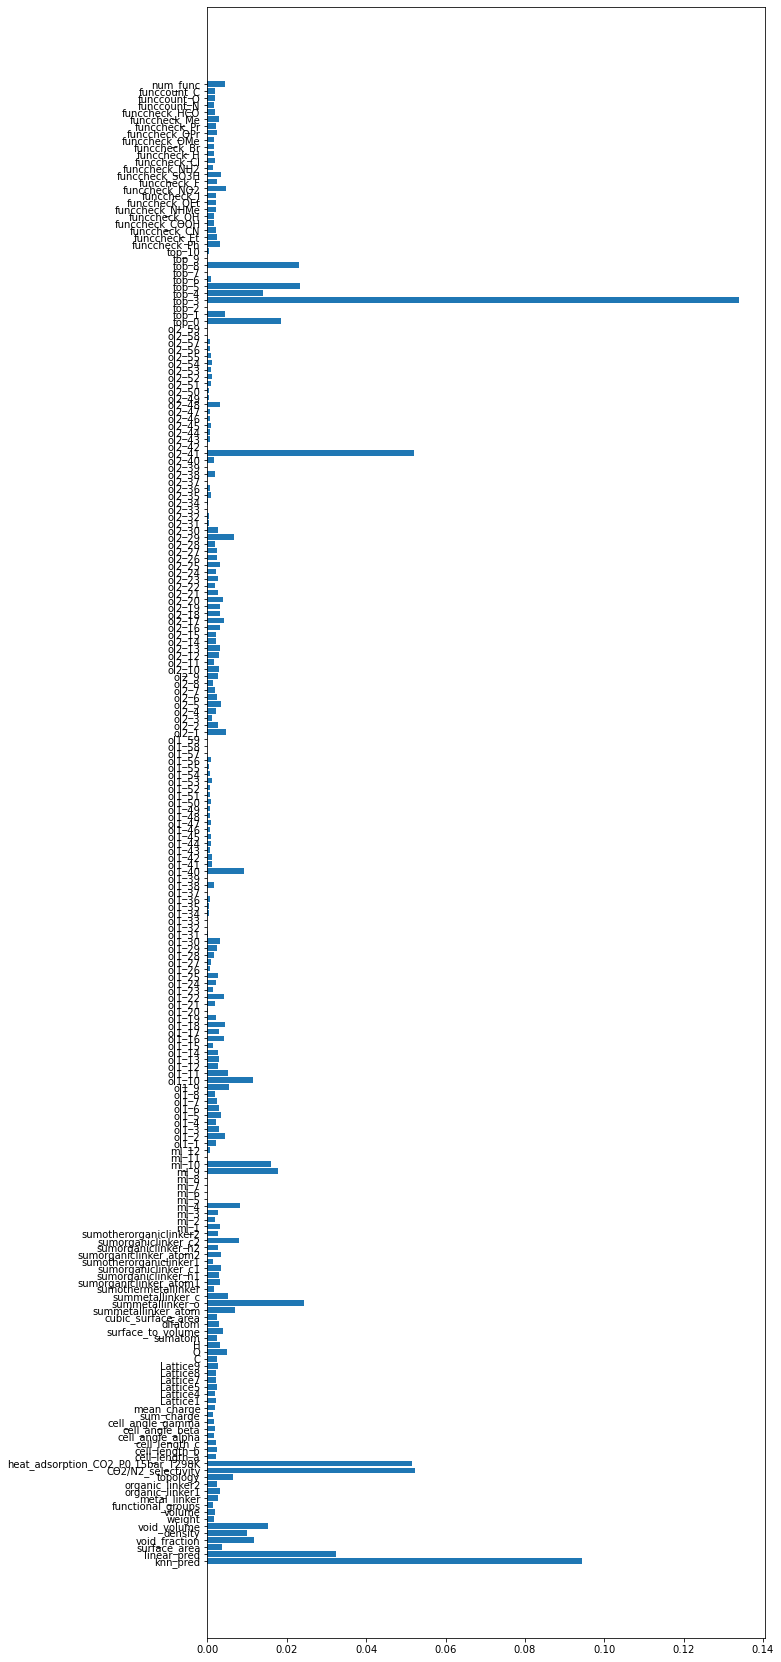

In [22]:
plt.figure(figsize=(10,30))
plt.barh(df_selected.columns, xg_reg1.feature_importances_);plt.show()

In [23]:
pred_df = pd.DataFrame([pred,y_test]).T;pred_df

,0,1
0,61.203545,56.966266
1,123.881584,118.048881
2,151.933502,153.904993
3,67.155602,84.776712
4,302.630219,335.420193
...,...,...
6824,15.461395,3.076697
6825,61.678337,60.128307
6826,148.697708,180.720357
6827,247.062851,231.299151


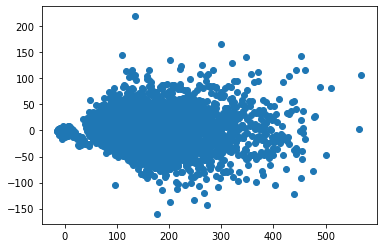

In [24]:
%matplotlib inline
plt.scatter(pred_df[0],pred_df[1]-(pred_df[0]));plt.show()

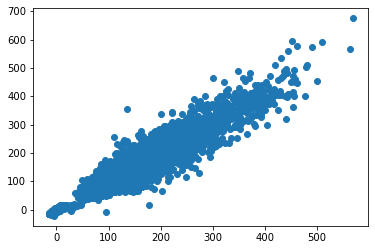

In [25]:
plt.scatter(pred_df[0],pred_df[1]);plt.show()

<h1>Evaluation</h1>

In [26]:
testset = pd.read_csv('Datasets/full_test.csv')
print(testset.shape);testset.head()

(17000, 48)


,MOFname,volume,density,weight,surface_area,void_fraction,void_volume,functional_groups,metal_linker,organic_linker1,...,summetallinker_c,sumothermetallinker,sumorganiclinker_atom1,sumorganiclinker_h1,sumorganiclinker_c1,sumotherorganiclinker1,sumorganiclinker_atom2,sumorganiclinker_h2,sumorganiclinker_c2,sumotherorganiclinker2
0,mof_unit_68614,1208.301332,1.096273,797.70936,586.54,0.11392,0.1039,OEt,2,5,...,6,0,2,0,2,0,24,10,14,0
1,mof_unit_68615,4126.414623,1.502488,3733.65779,852.49,0.21367,0.1422,H-I,4,6,...,9,0,14,4,10,0,24,8,16,0
2,mof_unit_68616,1602.148373,0.774443,747.21048,3155.73,0.33883,0.4375,CN-OH,3,11,...,4,2,8,4,4,0,24,8,16,0
3,mof_unit_68617,2436.629312,0.678630,995.80232,3521.09,0.40464,0.5963,OMe,2,1,...,6,0,10,4,6,0,44,12,26,6
4,mof_unit_68618,3123.418006,0.711091,1337.53800,2678.46,0.38959,0.5479,NO2-Pr,3,8,...,4,2,22,8,12,2,4,0,4,0


In [27]:
test_func_data = {
    f'funccheck_{compound}':check_in(compound,loop=testset.functional_groups)
    for compound in compounds
}
test_func_data.update({
    f'funccount_{molecule}':count_in(molecule,loop=testset.functional_groups)
    for molecule in molecules
})
test_func_data.update({
    'num_func': [int('-' in str(x)) for x in testset.functional_groups]
})
testset.functional_groups = testset.functional_groups.astype("category").cat.codes
testset.topology = testset.topology.astype("category").cat.codes.astype(np.int64)
test_func_df = pd.DataFrame(test_func_data);test_func_df.head(5)

,funccheck_Ph,funccheck_Et,funccheck_CN,funccheck_COOH,funccheck_OH,funccheck_NHMe,funccheck_OEt,funccheck_I,funccheck_NO2,funccheck_F,...,funccheck_Br,funccheck_OMe,funccheck_OPr,funccheck_Pr,funccheck_Me,funccheck_HCO,funccount_N,funccount_O,funccount_C,num_func
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,1,1,0,1


In [28]:
test_metal_linker_int = testset['metal_linker']-1
test_metal_one_hot = to_categorical(test_metal_linker_int,num_classes=12,dtype='int8')
test_metal_onehot_df = pd.DataFrame(test_metal_one_hot,columns=['ml_' + str(num) for num in range(1,13)])
display(test_metal_onehot_df.head(3))
#-------------------------------------------------
test_org1_int = testset['organic_linker1']-1
test_org1_one_hot = to_categorical(test_org1_int,num_classes=59,dtype='int8')
test_org1_onehot_df = pd.DataFrame(test_org1_one_hot,columns=['ol1_' + str(num) for num in range(1,60)])
display(test_org1_onehot_df.head(3))
#-------------------------------------------------
test_org2_int = testset['organic_linker2']-1
test_org2_one_hot = to_categorical(test_org2_int,num_classes=59,dtype='int8')
test_org2_onehot_df = pd.DataFrame(test_org2_one_hot,columns=['ol2_' + str(num) for num in range(1,60)])
display(test_org2_onehot_df.head(3))
#-------------------------------------------------
test_top_int = testset['topology']
test_top_one_hot = to_categorical(test_top_int,dtype='int8')
test_top_onehot_df = pd.DataFrame(test_top_one_hot,columns=['top_' + str(num) for num in range(0,11)])
display(test_top_onehot_df.head(3))

,ml_1,ml_2,ml_3,ml_4,ml_5,ml_6,ml_7,ml_8,ml_9,ml_10,ml_11,ml_12
0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0


,ol1_1,ol1_2,ol1_3,ol1_4,ol1_5,ol1_6,ol1_7,ol1_8,ol1_9,ol1_10,...,ol1_50,ol1_51,ol1_52,ol1_53,ol1_54,ol1_55,ol1_56,ol1_57,ol1_58,ol1_59
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,ol2_1,ol2_2,ol2_3,ol2_4,ol2_5,ol2_6,ol2_7,ol2_8,ol2_9,ol2_10,...,ol2_50,ol2_51,ol2_52,ol2_53,ol2_54,ol2_55,ol2_56,ol2_57,ol2_58,ol2_59
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,top_0,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10
0,0,0,0,0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0


In [29]:
testset.insert(
    loc=0,
    column='difatom',
    value=testset['sumatom']-testset['C+O+H']
)
testset.insert(
    loc=0,
    column='surface_to_volume',
    value=testset['surface_area']/testset['volume']
)
testset.insert(
    loc=0,
    column='cubic_surface_area',
    value=((testset['volume']**(1/3))**2)*6
)

In [30]:
testset = testset[sum(df_col.values(),[])]
testset = pd.concat([testset,
test_metal_onehot_df,
test_org1_onehot_df,
test_org2_onehot_df,
test_top_onehot_df,
test_func_df
],axis=1);testset.head(3)

,surface_area,void_fraction,density,void_volume,weight,volume,functional_groups,metal_linker,organic_linker1,organic_linker2,...,funccheck_Br,funccheck_OMe,funccheck_OPr,funccheck_Pr,funccheck_Me,funccheck_HCO,funccount_N,funccount_O,funccount_C,num_func
0,586.54,0.11392,1.096273,0.1039,797.70936,1208.301332,260,2,5,26,...,0,0,0,0,0,0,0,1,0,0
1,852.49,0.21367,1.502488,0.1422,3733.65779,4126.414623,128,4,6,17,...,0,0,0,0,0,0,0,0,0,1
2,3155.73,0.33883,0.774443,0.4375,747.21048,1602.148373,34,3,11,17,...,0,0,0,0,0,0,1,1,1,1


In [31]:
test_scaled_data = linear_scaler.transform(testset)
test_scaled_data = pd.DataFrame(test_scaled_data)

test_pred = linear_reg.predict(test_scaled_data)
testset.insert(
    loc=0,
    column='linear_pred',
    value=test_pred
)

In [32]:
test_pred = neighbor_reg.predict(test_scaled_data)
test_pred = pd.DataFrame(test_pred,columns=['knn_pred'])
testset = pd.concat([test_pred,testset],axis=1);testset

,knn_pred,linear_pred,surface_area,void_fraction,density,void_volume,weight,volume,functional_groups,metal_linker,...,funccheck_Br,funccheck_OMe,funccheck_OPr,funccheck_Pr,funccheck_Me,funccheck_HCO,funccount_N,funccount_O,funccount_C,num_func
0,165.450215,180.303071,586.54,0.11392,1.096273,0.1039,797.70936,1208.301332,260,2,...,0,0,0,0,0,0,0,1,0,0
1,88.488590,85.488618,852.49,0.21367,1.502488,0.1422,3733.65779,4126.414623,128,4,...,0,0,0,0,0,0,0,0,0,1
2,59.799277,70.420258,3155.73,0.33883,0.774443,0.4375,747.21048,1602.148373,34,3,...,0,0,0,0,0,0,1,1,1,1
3,79.109832,80.928071,3521.09,0.40464,0.678630,0.5963,995.80232,2436.629312,300,2,...,0,1,0,0,0,0,0,1,0,0
4,40.990455,67.142914,2678.46,0.38959,0.711091,0.5479,1337.53800,3123.418006,258,3,...,0,0,0,1,0,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16995,-2.705902,36.347993,5720.14,0.77614,0.240160,3.2318,4723.68288,32660.944610,293,3,...,0,0,0,0,0,0,1,2,0,1
16996,1.245238,-20.275054,4017.28,0.59192,0.490903,1.2058,1499.13262,5070.998617,195,3,...,0,1,0,0,1,0,0,1,0,1
16997,9.977623,-17.892242,4288.76,0.54950,0.470109,1.1689,1322.04892,4669.804446,182,2,...,0,0,0,0,1,0,1,0,1,1
16998,29.360647,0.592133,4331.86,0.60643,0.430379,1.4091,1213.51148,4682.120862,288,3,...,0,0,0,0,0,1,0,2,1,1


check validation

In [33]:
print(f'{len(testset.columns)} : {len(df_selected.columns)}')
if(len(testset.columns)==len(df_selected.columns)):
    print(all(testset.columns == df_selected.columns))
    print(all(testset.dtypes == df_selected.dtypes))
else:print(False)

213 : 213
True
True


In [34]:
testset_array = np.array(testset);testset.shape

(17000, 213)

predict

In [35]:
# loadModel = xgb.Booster()
# loadModel.load_model('2914.json')

In [36]:
test_pred = xg_reg1.predict(testset_array);test_pred

array([ 1.7769096e+02,  6.7811920e+01,  6.1362663e+01, ...,
       -9.4548807e-02, -2.1025236e+00, -3.0178428e+00], dtype=float32)

convert to dataframe

In [37]:
submission = pd.DataFrame({
    "id": [str(i) for i in range(68614,85614)],
    "CO2_working_capacity [mL/g]":test_pred
    })
submission.head()

,id,CO2_working_capacity [mL/g]
0,68614,177.690964
1,68615,67.811920
2,68616,61.362663
3,68617,61.087158
4,68618,59.526943


save csv

In [38]:
submission.to_csv('submission.csv',index=False,float_format='%.7f')

--------------------------------------------------------------------------------------------